In [2]:
import pandas as pd

true_df = pd.read_csv('true.csv')
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
fake_df = pd.read_csv('fake.csv')
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
unique_subjects_fake = fake_df['subject'].unique()
unique_subjects_true = true_df['subject'].unique()
print(f"Categories in fake news: {unique_subjects_fake}")
print(f"Categories in true news: {unique_subjects_true}")

Categories in fake news: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
Categories in true news: ['politicsNews' 'worldnews']


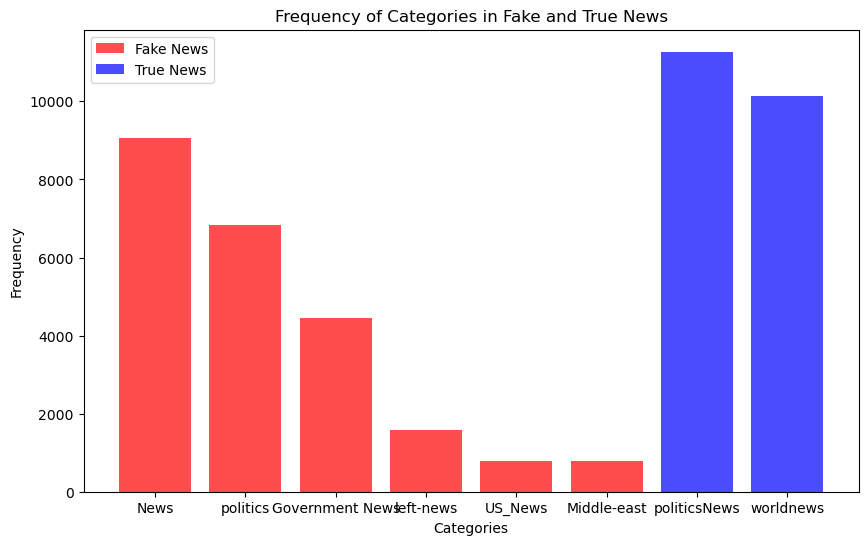

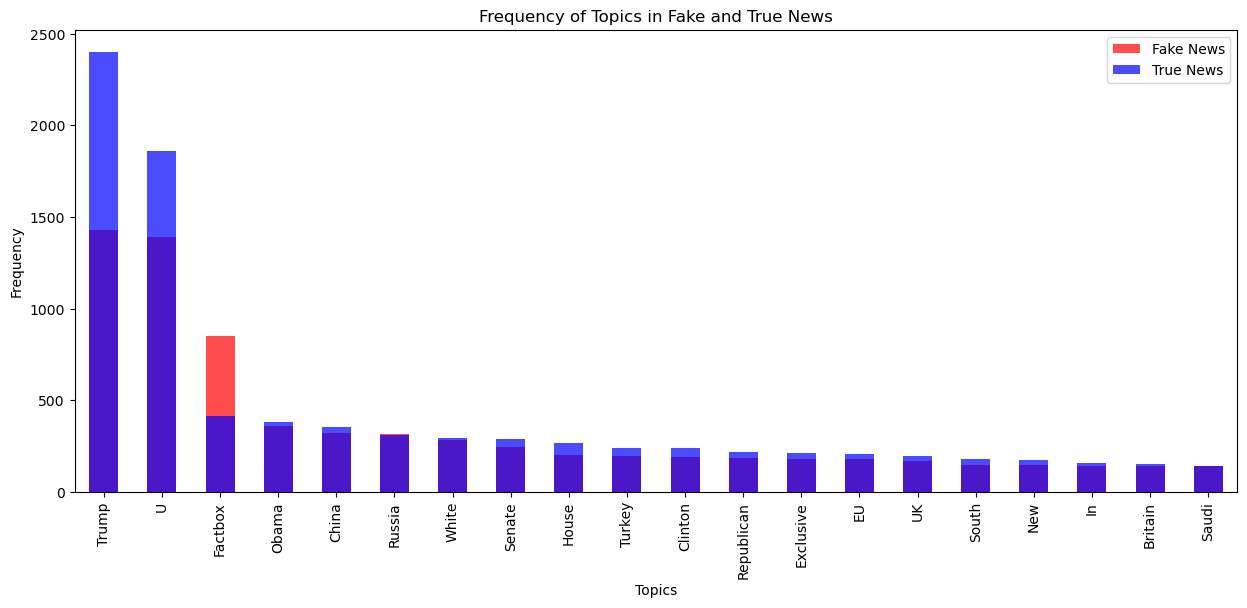

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(unique_subjects_fake, fake_df['subject'].value_counts(), color='red', alpha=0.7, label='Fake News')
plt.bar(unique_subjects_true, true_df['subject'].value_counts(), color='blue', alpha=0.7, label='True News')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Categories in Fake and True News')
plt.legend()
plt.show()

fake_topics = fake_df['title'].str.extract(r'([A-Za-z]+)')[0].value_counts()
true_topics = true_df['title'].str.extract(r'([A-Za-z]+)')[0].value_counts()

plt.figure(figsize=(15, 6))
fake_topics[:20].plot(kind='bar', color='red', alpha=0.7, label='Fake News')
true_topics[:20].plot(kind='bar', color='blue', alpha=0.7, label='True News')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Frequency of Topics in Fake and True News')
plt.legend()
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

fake_df['label'] = 1  
true_df['label'] = 0 

combined_df = pd.concat([true_df, fake_df])

combined_df['cleaned_text'] = combined_df['title'] + ' ' + combined_df['text']

combined_df['cleaned_text'] = combined_df['cleaned_text'].apply(lemmatize_text)

X = combined_df['cleaned_text']
y = combined_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

batch_size = 1000
with tqdm(total=len(X_train)) as pbar:
    for batch in range(0, len(X_train), batch_size):
        X_batch = X_train.iloc[batch:batch + batch_size]
        y_batch = y_train.iloc[batch:batch + batch_size]

        X_batch_vect = pipeline.named_steps['tfidf_vectorizer'].fit_transform(X_batch)
        
        pipeline.named_steps['random_forest'].fit(X_batch_vect, y_batch)
        pbar.update(len(X_batch))

X_test_vect = pipeline.named_steps['tfidf_vectorizer'].transform(X_test)
y_pred = pipeline.named_steps['random_forest'].predict(X_test_vect)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 35918/35918 [00:16<00:00, 2217.31it/s]


Accuracy: 0.9757238307349666
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      4330
           1       0.99      0.96      0.98      4650

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

fake_news_df = combined_df[combined_df['label'] == 1]

vectorizer = CountVectorizer(stop_words='english')
X_fake = vectorizer.fit_transform(fake_news_df['cleaned_text'])

lda_fake = LatentDirichletAllocation(n_components=5, random_state=42)
lda_fake.fit(X_fake)

feature_names_fake = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_fake.components_):
    top_keywords_idx = topic.argsort()[:-10-1:-1]
    top_keywords = [feature_names_fake[i] for i in top_keywords_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")



Topic 1: ha, state, people, said, year, obama, law, wa, country, government
Topic 2: wa, ha, medium, news, said, war, syria, military, story, obama
Topic 3: trump, clinton, wa, hillary, ha, president, said, election, obama, campaign
Topic 4: wa, police, said, black, gun, people, year, video, officer, ha
Topic 5: trump, wa, ha, donald, president, people, just, said, like, video


In [12]:
topics = [
    "ha, state, people, said, year, obama, law, wa, country, government",
    "wa, ha, medium, news, said, war, syria, military, story, obama",
    "trump, clinton, wa, hillary, ha, president, said, election, obama, campaign",
    "wa, police, said, black, gun, people, year, video, officer, ha",
    "trump, wa, ha, donald, president, people, just, said, like, video"
]

topic_names = {
    "ha, state, people, said, year, obama, law, wa, country, government": "Immigration & Politics",
    "wa, ha, medium, news, said, war, syria, military, story, obama": "Global Affairs & Security",
    "trump, clinton, wa, hillary, ha, president, said, election, obama, campaign": "Political Scandals",
    "wa, police, said, black, gun, people, year, video, officer, ha": "Police Shootings & Rights",
    "trump, wa, ha, donald, president, people, just, said, like, video": "Trump's Presidency & Commentary"
}

for i, topic in enumerate(topics):
    topics[i] = topic_names.get(topic, topic)

for i, topic in enumerate(topics, 1):
    print(topic)


Immigration & Politics
Global Affairs & Security
Political Scandals
Police Shootings & Rights
Trump's Presidency & Commentary


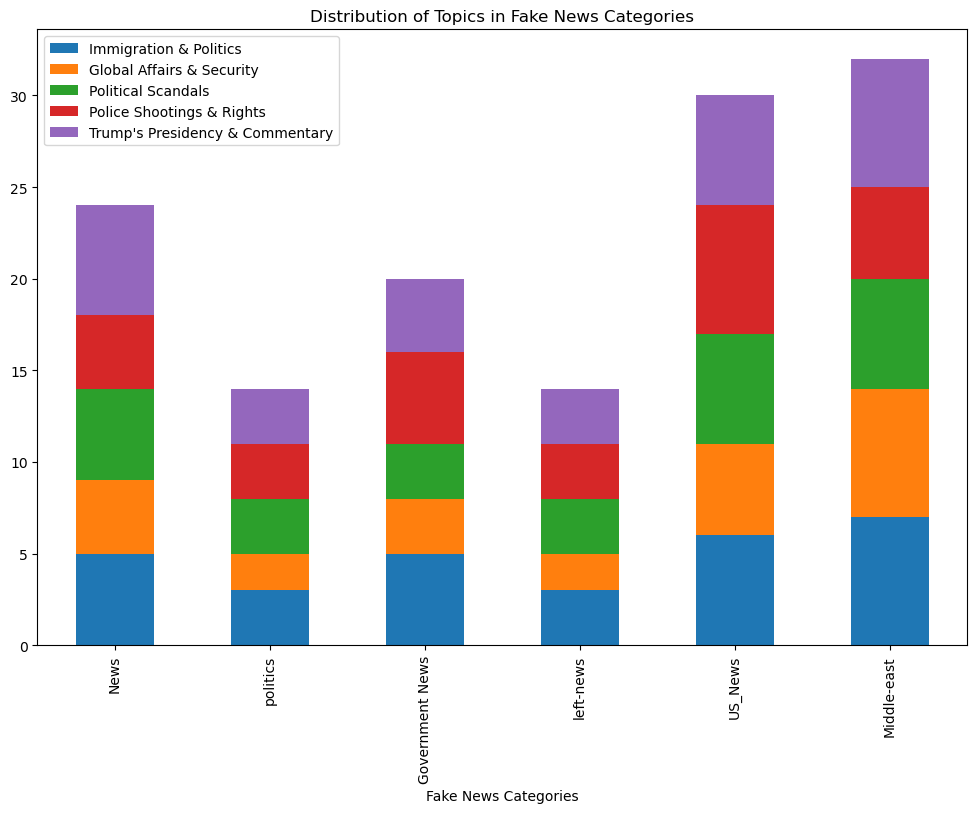

In [13]:
lda_topics = {
    'Immigration & Politics': ['said', 'wa', 'police', 'ha', 'year', 'government', 'people', 'reuters', 'state', 'attack'],
    'Global Affairs & Security': ['wa', 'ha', 'medium', 'news', 'said', 'war', 'syria', 'military', 'story', 'obama'],
    'Political Scandals': ['trump', 'clinton', 'wa', 'hillary', 'ha', 'president', 'said', 'election', 'obama', 'campaign'],
    'Police Shootings & Rights': ['wa', 'police', 'said', 'black', 'gun', 'people', 'year', 'video', 'officer', 'ha'],
    "Trump's Presidency & Commentary": ['trump', 'wa', 'ha', 'donald', 'president', 'people', 'just', 'said', 'like', 'video']
}

fake_news_df = combined_df[combined_df['label'] == 1]

df_topic_counts = pd.DataFrame(index=fake_news_df['subject'].unique(), columns=lda_topics.keys())

for index, row in fake_news_df.iterrows():
    cleaned_text = row['cleaned_text']
    for topic in lda_topics.keys():
        words = lda_topics[topic]
        count = sum(word in cleaned_text for word in words)
        df_topic_counts.at[row['subject'], topic] = count

fig, ax = plt.subplots(figsize=(12, 8))

df_topic_counts.plot(kind='bar', stacked=True, ax=ax)

plt.title('Distribution of Topics in Fake News Categories')
plt.xlabel('Fake News Categories')

plt.show()


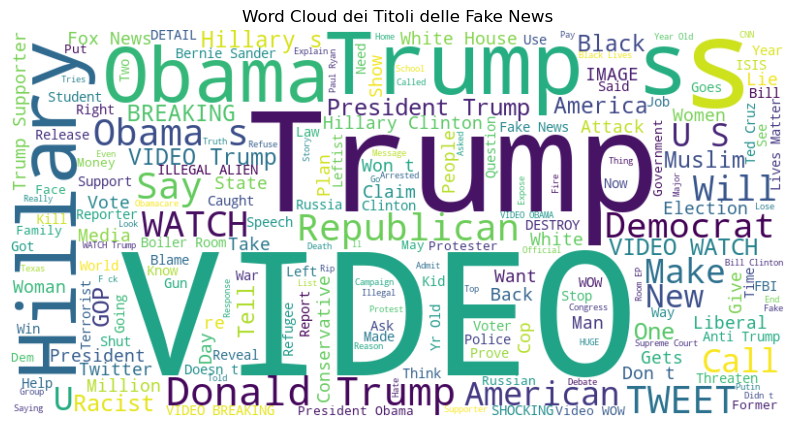

In [15]:
from wordcloud import WordCloud
fake_titles = combined_df[combined_df['label'] == 1]['title']

fake_titles_text = ' '.join(fake_titles)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_titles_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud dei Titoli delle Fake News')
plt.show()


In [16]:
import pickle

with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)